## **Analysis: Which non-fossil fuel energy technology will have the best price in the future?**

### Datasources used for this analysis
 - energy-consumption-global
 - energy-cost

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution

%load_ext google.colab.data_table
%matplotlib inline

In [10]:
### ENERGY USAGE ANALYSIS
# Read and filter data
df_energy_usage = pd.read_csv("data/energy-consumption-global.csv")  # Most recent year = 2021
df_energy_usage.drop(['Code', 'Traditional biomass (TWh, substituted energy)', 'Coal (TWh, substituted energy)',
                      'Oil (TWh, substituted energy)', 'Gas (TWh, substituted energy)'], axis=1, inplace=True)
df_energy_usage = df_energy_usage[df_energy_usage['Year'] > 1950]    # Dropping data before 1950
df_energy_usage.rename(columns={'Other renewables (TWh, substituted energy)': 'Other renewables',
                                'Biofuels (TWh, substituted energy)': 'Biofuels',
                                'Solar (TWh, substituted energy)': 'Solar',
                                'Wind (TWh, substituted energy)': 'Wind',
                                'Hydropower (TWh, substituted energy)': 'Hydropower',
                                'Nuclear (TWh, substituted energy)': 'Nuclear'}, inplace=True)

# Calculate the relative increase for each energy source
energy_sources = ['Other renewables', 'Biofuels', 'Solar', 'Wind', 'Hydropower', 'Nuclear']
for source in energy_sources:
    df_energy_usage[f'{source} - change %'] = df_energy_usage[source].pct_change() * 100

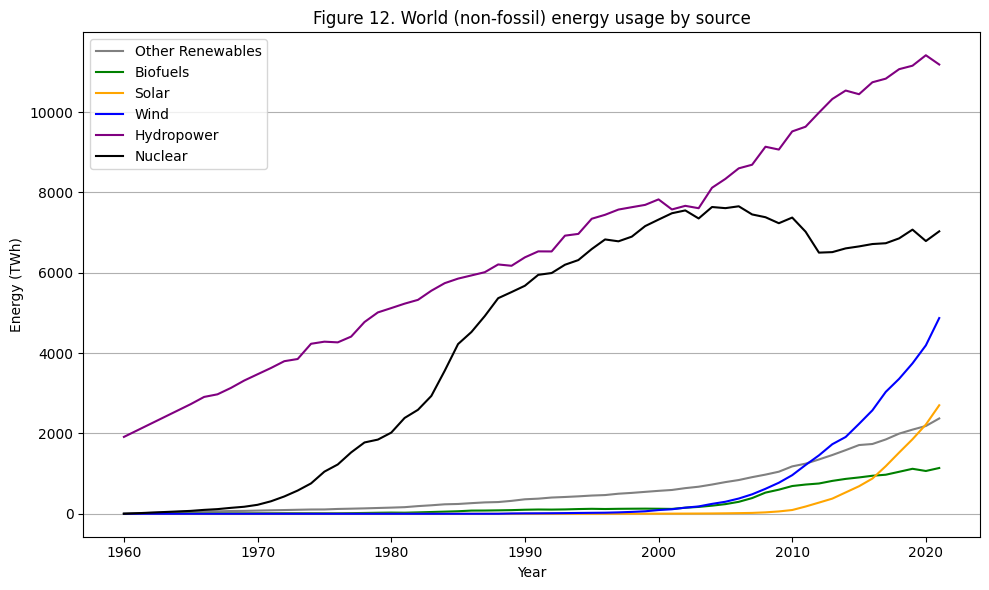

In [16]:
## CREATE A LINE CHART

# Extract the data for each energy source
years = df_energy_usage['Year']
other_renewables = df_energy_usage['Other renewables']
biofuels = df_energy_usage['Biofuels']
solar = df_energy_usage['Solar']
wind = df_energy_usage['Wind']
hydropower = df_energy_usage['Hydropower']
nuclear = df_energy_usage['Nuclear']

plt.figure(figsize=(10, 6))

plt.plot(years, other_renewables, label='Other Renewables', color='grey')
plt.plot(years, biofuels, label='Biofuels', color='green')
plt.plot(years, solar, label='Solar', color='orange')
plt.plot(years, wind, label='Wind', color='blue')
plt.plot(years, hydropower, label='Hydropower', color='purple')
plt.plot(years, nuclear, label='Nuclear', color='black')

plt.xlabel('Year')
plt.ylabel('Energy (TWh)')
plt.title('Figure 12. World (non-fossil) energy usage by source')
plt.grid(axis='y')

plt.legend()
plt.tight_layout()

Figure 12. (see above) shows the worlds (non-fossil) energy usage by source.

With this figure I want to show which energy sources are growing fastest. A **fast growing market** often goes together with investments and technological advancements. Due **technological advancements** it's more likely that these energy sources become **more efficient and (relatively) less expensive**.

From this figure it's clear that **'Solar'** and **'Wind'** are the fastest growing energy sources by usage. Due this fact I will keep my main focus on these two energy sources for this analysis.

In [12]:
### ENERGY COST ANALYSIS
# Read and filter data
df_energy_cost = pd.read_csv("data/energy-cost.csv")  # Most recent year = 2021
df_energy_cost.drop(['Code'], axis=1, inplace=True)
df_energy_cost = df_energy_cost[df_energy_cost['Year'] > 2000]    # Dropping data before 2000
df_energy_cost.rename(columns={'Bioenergy levelized cost of energy': 'Bio-energy',
                                'Geothermal levelized cost of energy': 'Giothermal',
                                'Solar photovoltaic levelized cost of energy': 'Solar (photovoltaic)',
                                'Concentrated solar power levelized cost of energy': 'Solar (concentrated)',
                                'Hydropower levelized cost of energy': 'Hydropower',
                                'Offshore wind levelized cost of energy': 'Wind (offshore)',
                                'Onshore wind levelized cost of energy': 'Wind (onshore)'}, inplace=True)

df_energy_cost.loc[df_energy_cost['Year'] == 2011, 'Giothermal'] = 0.06807  # Update missing value with average of surrounding values
df_energy_cost = df_energy_cost[df_energy_cost['Entity'] == "World"]
df_energy_cost = df_energy_cost.sort_values('Year')

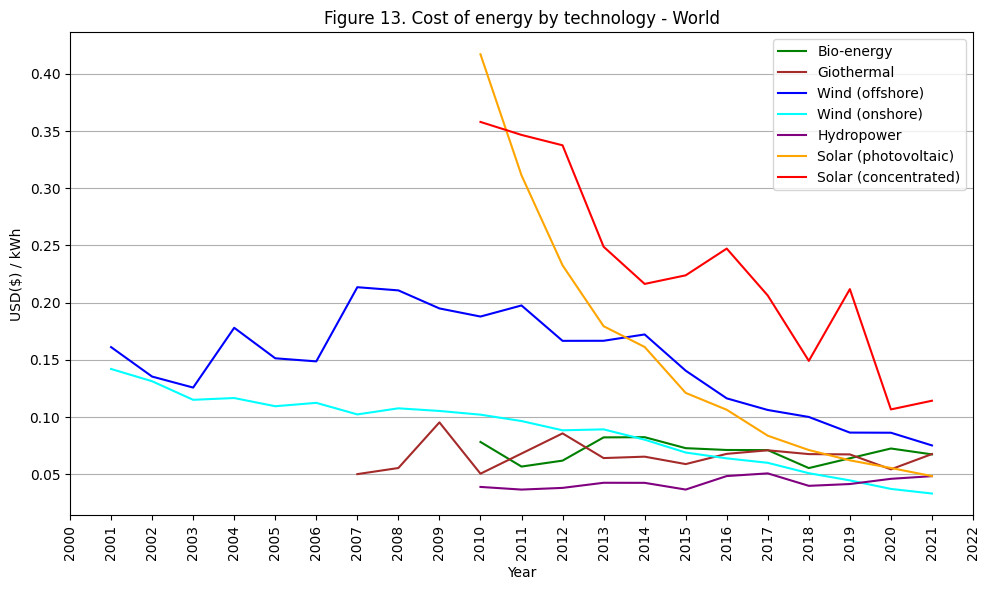

In [15]:
## CREATE A LINE CHART

# Extract the data for each energy source
years = df_energy_cost['Year']
bio_energy = df_energy_cost['Bio-energy']
giothermal = df_energy_cost['Giothermal']
wind_offshore = df_energy_cost['Wind (offshore)']
wind_onshore = df_energy_cost['Wind (onshore)']
hydropower = df_energy_cost['Hydropower']
solar_photo = df_energy_cost['Solar (photovoltaic)']
solar_conc = df_energy_cost['Solar (concentrated)']

plt.figure(figsize=(10, 6))

plt.plot(years, bio_energy, label='Bio-energy', color='green')
plt.plot(years, giothermal, label='Giothermal', color='brown')
plt.plot(years, wind_offshore, label='Wind (offshore)', color='blue')
plt.plot(years, wind_onshore, label='Wind (onshore)', color='cyan')
plt.plot(years, hydropower, label='Hydropower', color='purple')
plt.plot(years, solar_photo, label='Solar (photovoltaic)', color='orange')
plt.plot(years, solar_conc, label='Solar (concentrated)', color='red')

plt.xlabel('Year')
plt.ylabel('USD($) / kWh')
plt.title('Figure 13. Cost of energy by technology - World')
plt.grid(axis='y')

# Adjust x-ticks to display as integers
plt.xticks(range(int(min(plt.xticks()[0])), int(max(plt.xticks()[0])) + 1), rotation=90)

plt.legend()
plt.tight_layout()

Figure 13. (see above) shows the worlds energy costs by technology.

As expected from the 'Energy Usage Analysis' this figure shows that energy **prices are decreasing fastest** for **'Solar'** and **'Wind'** technologies.

This figure also shows that **other technologies** have a **stable price** movement, which makes it more likely that **'Solar'** and **'Wind'** technologies have better (cheapier) prices than other technologies in the future.

**'Solar'** is a **newer technology** compared to 'Wind', therefor there is less histocial data avaible. While **'Wind'** is showing a **steady decrease in price** over the last 10 year, **'Solar'** has the **fastest decreasing prices**.

Currently **<u>'Wind (onshore)'</u>** has the **best price** per kWh.

In [17]:
### FUTURE ENERGY COST ANALYSIS
# Dropping data before 2010 because solar energy data starts at this year
df_energy_cost = df_energy_cost[df_energy_cost['Year'] >= 2010]

# Prepare data for exponential regression
X = df_energy_cost['Year'].values

# Columns to perform exponential regression and forecast
columns = ['Wind (offshore)', 'Wind (onshore)', 'Solar (photovoltaic)', 'Solar (concentrated)']

# Perform exponential regression and forecast for each column
df_energy_cost_future = pd.DataFrame({'Year': np.arange(2021, 2032)})

# Define the separate values for parameter 'd' for each column
d_values = [0.0565, 0.0214, 0.0153, 0.0735]

for i, col in enumerate(columns):
    y = df_energy_cost[col].values

    # Define the exponential function with separate parameter 'd'
    def exponential_func(x, a, b, c, d):
        return 3 * a * np.exp(-0.2 * b * (x - c)) + d

    ## Parameter a: This parameter represents the amplitude or scale factor of the exponential function. It determines the overall vertical scaling of the curve
    ## Parameter b: This parameter controls the rate of exponential decay. It determines how quickly the values decrease as x increases.
    ## Parameter c: This parameter represents the horizontal shift or translation of the curve along the x-axis. It determines the position of the curve on the x-axis.
    ## Parameter d: This parameter represents the vertical shift or translation of the curve along the y-axis. It determines the baseline or offset of the curve.

    # Perform curve fitting using differential evolution
    bounds = [(0, max(y) * 10), (0, 1), (min(X), max(X)), (min(y), max(y))]
    result = differential_evolution(lambda p: np.mean((exponential_func(X, *p) - y) ** 2), bounds)
    popt = result.x

    # Assign the corresponding 'd' value for the current column
    d_param = d_values[i]
    popt[-1] = d_param

    # Perform forecast for the future years using the fitted parameters
    forecast_values = exponential_func(df_energy_cost_future['Year'], *popt)

    # Add forecast values to the DataFrame
    df_energy_cost_future[col] = forecast_values

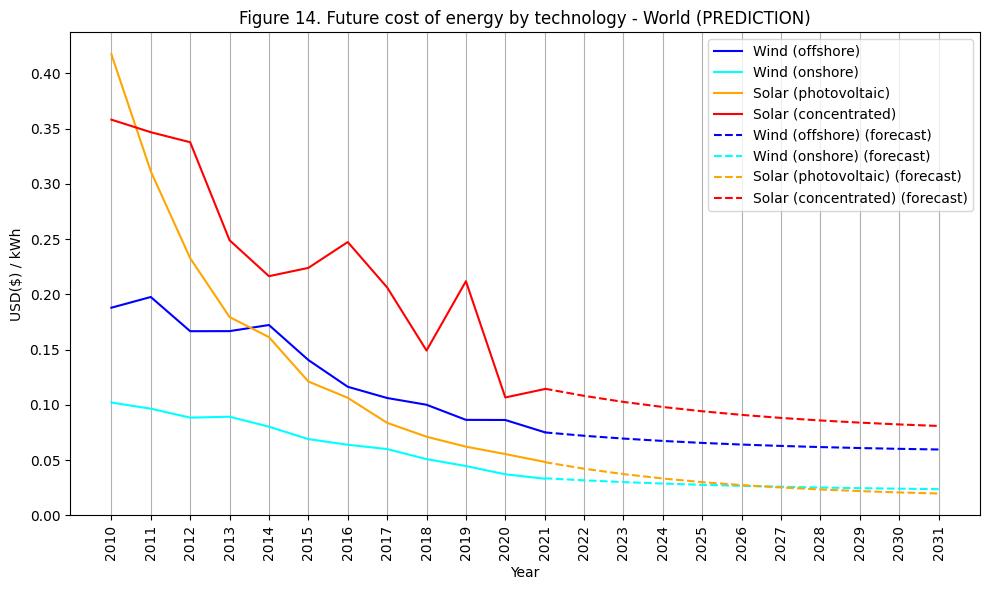

In [21]:
## CREATE A LINE CHART (FUTURE PRICE PREDICTION)
colors = ['blue', 'cyan', 'orange', 'red']

plt.figure(figsize=(10, 6))

# Plot the original data
for i, col in enumerate(columns):
    plt.plot(df_energy_cost['Year'], df_energy_cost[col], color=colors[i], label=col)

# Plot the forecasted values
for i, col in enumerate(columns):
    plt.plot(df_energy_cost_future['Year'], df_energy_cost_future[col], linestyle='dashed', color=colors[i], label=f'{col} (forecast)')

plt.xlabel('Year')
plt.ylabel('USD($) / kWh')
plt.title('Figure 14. Future cost of energy by technology - World (PREDICTION)')
plt.grid(axis='x')

plt.xticks(range(2010, 2032), rotation=90)

plt.legend()
plt.tight_layout()

Figure 14. (see above) shows the prediction of energy cost by technology.

It's very hard to predict future prices for energy. At first I have tried to apply a **linear regression** but this **caused prices to go negative** pretty soon and negative prices are **not realistic** for energy.

Therefor I have applied **'Simple Exponential Smoothing (SES)'**. The same SES is applied to each energy technology.

_SES (Simple Exponential Smoothing) is a basic forecasting method that assigns exponentially decreasing weights to past observations, where the forecast is based on the weighted average of historical data, placing more emphasis on recent values._

As noted in the 'Energy Cost Analysis' this figure shows that energy **prices are decreasing faster** for **'Solar'** then for 'Wind' technologies.






## **Conclusion: Which non-fossil fuel energy technology will have the best price in the future?**

- **'Solar'** and **'Wind'** are the fastest growing energy sources by usage;
- **'Solar'** technology has the **fastest decreasing prices**;
- **'Wind'** technology is showing a slower but **steady decrease in price**;
- Currently **'Wind (onshore)'** has the best price.

<br>

Due the faster decrease in price for **'Solar (photovoltaic)'** it's likely to become **better in price than 'Wind (onshore)'** around the **year 2026-2027**.

This analyses shows that **<u>'Solar (photovoltaic)'</u>**, is the non-fossil fuel energy technology, that will have the **best price in the (near) future**.